In [1]:
import pymc3 as pm
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# these are unknown
true_p_A = 0.05
true_p_B = 0.04

# also unequal sample sizes
N_A = 1500
N_B = 750

# artificial observations
obs_A = stats.bernoulli.rvs(true_p_A, size=N_A)
obs_B = stats.bernoulli.rvs(true_p_B, size=N_B)

print("Obs from Site A: ", obs_A[:30], "...")
print("Obs from Site B: ", obs_B[:30], "...")

print(np.mean(obs_A))
print(np.mean(obs_B))

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0] ...
0.054
0.02666666666666667


In [3]:
with pm.Model() as model:
    p_A = pm.Uniform('p_A', lower=0, upper=1)
    p_B = pm.Uniform('p_B', lower=0, upper=1)

    delta = pm.Deterministic('delta', p_A - p_B)

    obs_A = pm.Bernoulli('obs_A', p_A, observed=obs_A)
    obs_B = pm.Bernoulli('obs_B', p_B, observed=obs_B)

    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace = trace[1000:]

/home/arc/miniconda3/envs/pyalcs-experiments/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [4]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

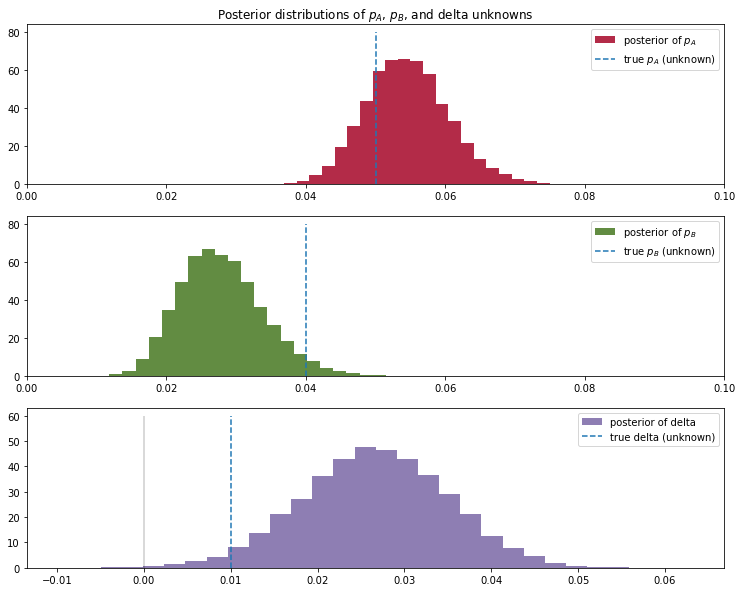

In [5]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

## Cheating students

In [10]:
import theano.tensor as tt

N = 100  # population size
X = 35  # observed value

with pm.Model() as model1:
    p = pm.Uniform('freq_cheating', 0, 1)
    true_answers = pm.Bernoulli('truths', p, shape=N, testval=np.random.binomial(1, 0.5, N))

    first_coin_flips = pm.Bernoulli('first_flips', 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))

    second_coin_flips = pm.Bernoulli('second_flips', 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))

    val = first_coin_flips * true_answers + (1- first_coin_flips) * second_coin_flips

    observed_proportion = pm.Deterministic('observed_proportion', tt.sum(val) / float(N))

    observations = pm.Binomial('obs', N, observed_proportion, observed=X)

In [68]:
observed_proportion

AttributeError: 'DeterministicWrapper' object has no attribute 'random'

In [11]:
with model1:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

/home/arc/miniconda3/envs/pyalcs-experiments/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [freq_cheating]
>BinaryGibbsMetropolis: [truths, first_flips, second_flips]


Sampling 4 chains for 1_000 tune and 40_000 draw iterations (4_000 + 160_000 draws total) took 660 seconds.
The number of effective samples is smaller than 10% for some parameters.


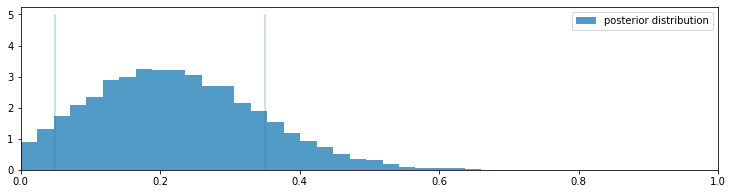

In [12]:
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"][15000:]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30,
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();